<a href="https://colab.research.google.com/github/refercon/ipynb/blob/main/Paper_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset initializaion

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
!pip install deap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
drive.mount('/content/drive')
grid_size = 20

dataset = 1 # 1:T-Drive, 2:San-Francis, 3:GEOLIFE
# Load the dataset
num_trustworthy_workers = 20
num_untrustworthy_workers = 60
workers_num = num_trustworthy_workers + num_untrustworthy_workers

if 1 == dataset:
  file_path = '/content/drive/MyDrive/paper-4/T-Drive.csv'#T-Drive
  GT_FILE = '/content/drive/MyDrive/data/AQ_GTD2.csv'
  UN_FILE = '/content/drive/MyDrive/data/AQ_unkown.csv'
elif 2 == dataset:
  file_path = '/content/drive/MyDrive/paper-4/San-Francis.csv'#This dataset contains mobility traces of taxi cabs in San Francisco,
  GT_FILE = '/content/drive/MyDrive/data/AEP_GTD.csv'
  UN_FILE = '/content/drive/MyDrive/data/AEP_unkown.csv'
elif 3 == dataset:
  file_path = '/content/drive/MyDrive/paper-4/GEOLIFE.csv'#This dataset contains mobility traces of taxi cabs in San Francisco,
  GT_FILE = '/content/drive/MyDrive/data/AEP_GTD.csv'
  UN_FILE = '/content/drive/MyDrive/data/AEP_unkown.csv'

data = pd.read_csv(file_path, header=None, names=['worker_id', 'latitude', 'longitude'])
# Randomly select 900 data points

selected_data = data.sample(n=grid_size * grid_size, random_state=0)
# Function to normalize the coordinates to fit a 30x30 grid
def normalize_coordinates(lat, lon, grid_size):
    min_lat, max_lat = lat.min(), lat.max()
    min_lon, max_lon = lon.min(), lon.max()
    # Normalize latitude and longitude to a scale of 0 to grid_size-1
    norm_lat = ((lat - min_lat) / (max_lat - min_lat) * (grid_size - 1)).astype(int)
    norm_lon = ((lon - min_lon) / (max_lon - min_lon) * (grid_size - 1)).astype(int)
    return norm_lat, norm_lon
# Function to map workers to the grid with their identifiers
def map_workers_to_grid_with_identifier(workers, grid_size):
    # Normalize the coordinates
    norm_lat, norm_lon = normalize_coordinates(workers['latitude'], workers['longitude'], grid_size)
    # Initialize the grid with empty strings
    grid_map = np.full((grid_size, grid_size), '', dtype=object)

    # Place each worker in the grid with identifier "w" followed by the index
    for index, (lat, lon) in enumerate(zip(norm_lat, norm_lon)):
        worker_id = f'w{index+1}'  # Adding 1 to start the index from 1

        # Find the next available spot if the current one is taken
        while grid_map[lat, lon] != '':
            lon = (lon + 1) % grid_size
            if lon == 0:
                lat = (lat + 1) % grid_size
        # Place the worker identifier in the grid
        grid_map[lat, lon] = worker_id

    return grid_map

# Map the selected 900 workers to the grid with identifiers

worker_grid_map_with_id = map_workers_to_grid_with_identifier(selected_data, grid_size)
df_grid_map_with_id = pd.DataFrame(worker_grid_map_with_id)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.7 MB/s eta 0:00:00
Mounted at /content/drive


# Grid initialization

In [ ]:
import random
import numpy as np
import pandas as pd

# 初始化和数据准备
if dataset == 1:
    random.seed(6)
elif dataset == 3:
    random.seed(10)
else:
    random.seed(45)

# 找出所有工人的位置
worker_positions = random.sample(list(zip(*np.where(df_grid_map_with_id.apply(lambda x: x.str.startswith('w'))))), workers_num)

# 创建工人名称列表（w1, w2, ..., w[workers_num]）
workers = [f'w{i+1}' for i in range(workers_num)]

# 任务标识符集（t1, t2, ..., t[workers_num]）
tasks = [f't{i+1}' for i in range(workers_num)]

# 初始化新的网格
new_grid_map = np.full((grid_size, grid_size), '', dtype=object)

# 将工人放置到原始位置，使用连续的工人名称
for idx, (worker_row, worker_col) in enumerate(worker_positions):
    new_grid_map[worker_row, worker_col] = workers[idx]  # 修改这里，使用连续的工人名称

# 放置任务尽量远离工人
tasks_placed = 0
for i, task in enumerate(tasks):
    worker_row, worker_col = worker_positions[i]

    # 计算每个空白格子与当前工人的曼哈顿距离
    empty_cells = [(r, c) for r in range(grid_size) for c in range(grid_size) if new_grid_map[r, c] == '']
    distances = {cell: abs(cell[0] - worker_row) + abs(cell[1] - worker_col) for cell in empty_cells}

    # 选择最远距离的格子
    max_distance = max(distances.values())
    farthest_cells = [cell for cell, dist in distances.items() if dist == max_distance]
    chosen_cell = random.choice(farthest_cells)

    # 放置任务
    new_grid_map[chosen_cell[0], chosen_cell[1]] = task
    tasks_placed += 1

# 转换新网格为DataFrame以便可视化
df_new_grid_map = pd.DataFrame(new_grid_map)
df_new_grid_map


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,w7,t1,t16,t21,t30,t56,,,,,,w17,,t79,w59,t42,t25,t12,w6,t3
1,t4,t13,t19,w47,t55,t57,,,,,,,,,t76,t62,t48,t39,t11,t10
2,t9,w2,t23,t32,,w34,,w37,w26,w46,,,,,,t63,t54,t41,t28,w70
3,t22,w66,t50,t67,,,,,,,w78,,,,w8,,t68,t52,t44,t29
4,t24,t33,t58,,,,,,,,,,,,,,,t74,w27,w53
5,w43,w20,w49,,,,,w80,,,,,,,w77,,,,t69,t60
6,t71,,,,,w61,,,w40,,,,,w5,,w31,,w72,,w18
7,,,,,,,,,,w45,,,,,,w64,,,,w73
8,,,,w15,,,,,,,,w36,,,,,,,,
9,,,w65,,w51,w38,,,,,,w14,,,w75,,,,,


# Data conversion

In [ ]:
# Extracting worker and task information in the specified format
import re
def extract_entities(grid_map):
    tasks = []
    workers = []
    for row_idx, row in enumerate(grid_map):
        for col_idx, cell in enumerate(row):
            if cell.startswith('w'):  # It's a worker
                worker_id = cell[1:]  # Remove the 'w' to get the numeric ID
                workers.append({"id": 'w' + worker_id, "location": (row_idx+1, col_idx+1)})
            elif cell.startswith('t'):  # It's a task
                task_id = cell[1:]  # Remove the 't' and convert to int
                tasks.append({"id": 't' + task_id, "location": (row_idx+1, col_idx+1)})

    return tasks, workers

tasks, workers = extract_entities(df_new_grid_map.to_numpy())

# Convert workers list to a dictionary
workers = {worker["id"]: worker["location"] for worker in workers}
# Convert tasks list to a dictionary
tasks = {task["id"]: task["location"] for task in tasks}

# first_two_workers = list(workers.items())[:2]
# # 将结果转换回字典格式
# workers = dict(list(workers.items())[:2])
len(workers),len(tasks)
sorted_tasks = sorted(tasks.items(), key=lambda item: int(re.search(r'\d+', item[0]).group()))
task_positions = [coord for _, coord in sorted_tasks]
task_positions = np.array(task_positions)

sorted_workers = sorted(workers.items(), key=lambda item: int(re.search(r'\d+', item[0]).group()))
worker_positions = [coord for _, coord in sorted_workers]
worker_positions = np.array(worker_positions)

In [ ]:
import numpy as np
import pandas as pd
# 设置随机种子以保证可重复性
random.seed(42)
np.random.seed(42)

# 假设网格为n×n
n = grid_size  # 例如5x5的网格
task_count = len(tasks)  # 假设有10个任务
worker_count = len(workers)
# 生成任务的价值
task_values = np.random.randint(50, 60, size=task_count)  # 随机生成任务价值
task_payments = np.random.randint(10, 20, size=task_count)  # 假设每个任务有一个随机基础报酬

# 计算任务之间的切比雪夫距离
def chebyshev_distance(p1, p2):
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))

distances = np.zeros((task_count, task_count))

for i in range(task_count):
    for j in range(i + 1, task_count):
        distance = chebyshev_distance(task_positions[i], task_positions[j])
        distances[i][j] = distances[j][i] = distance
len(tasks)
# worker_distances = np.zeros((worker_count, worker_count))
# for i in range(worker_count):
#     for j in range(i + 1, worker_count):
#         distance = chebyshev_distance(worker_positions[i], worker_positions[j])
#         worker_distances[i][j] = worker_distances[j][i] = distance

80

In [ ]:
import random
import numpy as np

# 设置随机种子以保证可重复性
random.seed(42)
np.random.seed(42)

# 生成基准数据
def generate_baseline_data(num_tasks, num_cycles):
    baseline_data = {}
    for task_id in range(1, num_tasks + 1):
        # baseline_data[task_id] = [random.randint(10, 20) for _ in range(num_cycles)]
        baseline_data[task_id] = [round(random.uniform(10, 20), 2) for _ in range(num_cycles)]
    return baseline_data

# 生成工人数据
def generate_worker_data(num_workers, baseline_data, consistency=0.9, start_index=1, none_probability=0.1):
    worker_data = {}
    for worker_id in range(start_index, start_index + num_workers):
        records = []
        for task_id, baseline_values in baseline_data.items():
            for cycle in range(len(baseline_values)):
                if random.random() < none_probability:
                    true_value = None  # 工人未提交数据
                else:
                    if random.random() < consistency:
                        true_value = baseline_values[cycle]  # 保持与基准一致
                    else:
                        # true_value = baseline_values[cycle] + random.choice([-3, -2, 2, 3])  # 与基准不一致
                        deviation = round(random.uniform(-3, 13), 2)
                        true_value = round(baseline_values[cycle] + deviation, 2)  # 与基准不一致
                records.append((cycle + 1, task_id, true_value))
        worker_data[f'w{worker_id}'] = records
    return worker_data

# 计算信任度
def compute_worker_trust(W_UNK_data, baseline_data, lambda_value, tolerance):
    trust_scores = {}
    trust_details = {}

    for worker_id, records in W_UNK_data.items():
        trust_sum = 0
        weight_sum = 0
        worker_trust_details = []  # 用于存储当前工人的每个周期的信任得分

        # 计算每个工人的信任度，按任务区分周期
        task_cycle_data = {}
        for time, task_id, true_value in records:
            if task_id not in task_cycle_data:
                task_cycle_data[task_id] = []
            task_cycle_data[task_id].append((time, true_value))

        # 处理每个任务，计算权重和信任度
        for task_id, task_records in task_cycle_data.items():
            n = len(task_records)  # 当前任务的周期数
            for k, (time, true_value) in enumerate(task_records, 1):
                baseline_value = baseline_data[task_id][time - 1]  # 基准数据对应的值
                if true_value is None:
                    trust = 0  # 未提交数据，得分为0
                else:
                    if baseline_value - (tolerance + 12) <= true_value <= baseline_value + (tolerance + 12):
                        trust = 1  # 在容差范围内，得分为1
                    else:
                        trust = -1  # 超出容差范围，得分为-1

                # 现在 k 的范围是 1 到 n
                weight = np.exp(-lambda_value * (n - k))  # 时间越近，权重越大
                trust_sum += weight * trust
                weight_sum += weight
                worker_trust_details.append((time,  weight * trust))  # 存储每个周期的信任度得分

        trust_scores[worker_id] = trust_sum / weight_sum if weight_sum != 0 else 0
        trust_details[worker_id] = worker_trust_details

    return trust_scores, trust_details

# 工人分类
def classify_workers(trust_scores, W_TRUSTWORTHY_ids):
    W_TRT = []
    W_UNT = []

    W_REL_trust_threshold = np.min([trust_scores[worker_id] for worker_id in W_TRUSTWORTHY_ids])

    for worker_id, trust_score in trust_scores.items():
        if trust_score >= W_REL_trust_threshold:
            W_TRT.append(worker_id)
        else:
            W_UNT.append(worker_id)

    return W_TRT, W_UNT, W_REL_trust_threshold

# 基本设置
num_tasks = task_count       # 任务数量
num_cycles = 10      # 检验周期
tolerance = 0

# 生成基准数据
baseline_data = generate_baseline_data(num_tasks, num_cycles)
# num_trustworthy_workers = 50
# num_untrustworthy_workers = 30
# 生成可信工人和不可信工人的数据，确保工人ID不冲突
trustworthy_worker_data = generate_worker_data(num_trustworthy_workers, baseline_data, consistency=1, start_index=1)
untrustworthy_worker_data = generate_worker_data(num_untrustworthy_workers, baseline_data, consistency=0.3, start_index=num_trustworthy_workers + 1)

# 合并所有工人的数据
W_UNK_data = {}
W_UNK_data.update(trustworthy_worker_data)
W_UNK_data.update(untrustworthy_worker_data)

# 确保合并后的工人数与生成的工人数一致
assert len(W_UNK_data) == (num_trustworthy_workers + num_untrustworthy_workers), "合并后的工人数不正确！"

# 获取可信工人ID列表
W_TRUSTWORTHY_ids = list(trustworthy_worker_data.keys())

# 计算所有工人的信任度
trust_scores, trust_details = compute_worker_trust(W_UNK_data, baseline_data, lambda_value=0.1, tolerance=tolerance)

# 分类工人，确保可信工人的信任度均值作为分类阈值
W_TRT, W_UNT, W_REL_trust_threshold = classify_workers(trust_scores, W_TRUSTWORTHY_ids)

# 输出分类结果
print("\n可信工人 (W_TRT):", W_TRT)
print("不可信工人 (W_UNT):", W_UNT)
# trust_details['w1']


可信工人 (W_TRT): ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20']
不可信工人 (W_UNT): ['w21', 'w22', 'w23', 'w24', 'w25', 'w26', 'w27', 'w28', 'w29', 'w30', 'w31', 'w32', 'w33', 'w34', 'w35', 'w36', 'w37', 'w38', 'w39', 'w40', 'w41', 'w42', 'w43', 'w44', 'w45', 'w46', 'w47', 'w48', 'w49', 'w50', 'w51', 'w52', 'w53', 'w54', 'w55', 'w56', 'w57', 'w58', 'w59', 'w60', 'w61', 'w62', 'w63', 'w64', 'w65', 'w66', 'w67', 'w68', 'w69', 'w70', 'w71', 'w72', 'w73', 'w74', 'w75', 'w76', 'w77', 'w78', 'w79', 'w80']


In [ ]:
# 计算每个任务的完成率
# 设置随机种子以保证可重复性
random.seed(42)
np.random.seed(42)
def compute_task_completion_rate(W_TRT, W_UNK_data, baseline_data, num_tasks,tolerance):
    task_completion_rates = []

    for task_id in range(1, num_tasks + 1):
        total_cycles = 0
        successful_cycles = 0

        # 收集参与该任务的可信工人的完成率
        for worker_id in W_TRT:
            records = W_UNK_data[worker_id]
            for record in records:
                rec_time, rec_task_id, true_value = record
                if rec_task_id == task_id:
                    total_cycles += 1
                    baseline_value = baseline_data[task_id][rec_time - 1]
                    if true_value is not None and baseline_value - 1 <= true_value <= baseline_value + 1:
                        successful_cycles += 1

        # 计算任务的完成率
        if total_cycles > 0:
            task_completion_rates.append(successful_cycles / total_cycles)
        else:
            task_completion_rates.append(None)  # 如果没有可信工人参与该任务

    # 将task_completion_rates 转换为 numpy array
    task_completion_array = np.array(task_completion_rates)

    return task_completion_array

# # 输出信任度结果
# print("\n信任度评分:")
# for worker_id, score in trust_scores.items():
#     print(f'{worker_id}: {score:.4f}')

# # 输出分类阈值
# print(f"\n使用的分类阈值 (W_REL_trust_threshold): {W_REL_trust_threshold}")
# 计算并输出每个任务的完成率
task_completion_rates = compute_task_completion_rate(W_TRT, W_UNK_data, baseline_data, num_tasks,tolerance=tolerance)

# 确保20%的任务完成率低于或等于0.5
popularity_threshold = 0.5

num_low_completion = 20#int(0.2 * num_tasks)  # 计算需要调整的任务数量
low_completion_indices = np.random.choice(num_tasks, num_low_completion, replace=False)  # 随机选择任务的索引

# 修改这些任务的完成率使其低于或等于0.5
for idx in low_completion_indices:
    task_completion_rates[idx] = random.uniform(0, popularity_threshold)
task_completion_rates


array([0.01250538, 0.885     , 0.92      , 0.885     , 0.21096091,
       0.885     , 0.905     , 0.9       , 0.885     , 0.875     ,
       0.44608978, 0.88      , 0.01489861, 0.885     , 0.86      ,
       0.85      , 0.9       , 0.905     , 0.36823561, 0.95      ,
       0.875     , 0.91      , 0.13751466, 0.89      , 0.87      ,
       0.91      , 0.885     , 0.875     , 0.33834974, 0.95      ,
       0.3197134 , 0.11160537, 0.895     , 0.25267764, 0.88      ,
       0.09941883, 0.85      , 0.88      , 0.925     , 0.885     ,
       0.00324938, 0.93      , 0.915     , 0.88      , 0.865     ,
       0.27247074, 0.88      , 0.91      , 0.89      , 0.10931899,
       0.905     , 0.925     , 0.91      , 0.87      , 0.95      ,
       0.40471523, 0.905     , 0.94      , 0.855     , 0.925     ,
       0.93      , 0.29463284, 0.905     , 0.905     , 0.915     ,
       0.875     , 0.9       , 0.01326798, 0.32494222, 0.915     ,
       0.04346942, 0.89      , 0.91      , 0.11022031, 0.875  

#RWIA

In [ ]:
# 计算推理出的真相与基准数据的偏差
def compute_truth_deviation(W_TRT_data, baseline_data):
    deviations = {}
    for task_id in baseline_data.keys():  # 遍历任务 ID
        task_inferred_values = []
        for worker_id, records in W_TRT_data.items():
            for time, task, true_value in records:
                if task == task_id and true_value is not None:
                    task_inferred_values.append(true_value)

        if task_inferred_values:  # 如果有工人提交了数据
            inferred_value = np.mean(task_inferred_values)  # 假设推理值为该任务工人数据的均值
            baseline_value = np.mean(baseline_data[task_id])  # 获取基准数据的均值
            deviation = abs(baseline_value - inferred_value) / baseline_value  # 计算偏差
            deviations[task_id] = deviation
        else:
            deviations[task_id] = None  # 没有数据的情况
    return deviations

# 假设 num_tasks 是任务的数量
W_TRT_data = {worker_id: W_UNK_data[worker_id] for worker_id in W_TRT}

# 计算真相与基准数据的偏差
deviations = compute_truth_deviation(W_TRT_data, baseline_data)

# 计算总偏差
total_deviations = 0
valid_tasks = 0
for task_id, deviation in deviations.items():
    if deviation is not None:
        total_deviations += deviation
        valid_tasks += 1

# 输出平均偏差
print(f"{total_deviations / valid_tasks:.4f}" if valid_tasks > 0 else "No valid data")


0.0035


#MEI

In [ ]:

# 用均值法推理W_UNK_data中的任务真相
def infer_truth_by_mean(W_TRT_data, num_tasks):
    inferred_truth = {}
    task_raw_data = {}  # 用来存储每个任务的原始数据

    # 遍历每个任务，推理任务真相
    for task_id in range(1, num_tasks + 1):
        values = []
        task_raw_data[task_id] = []  # 初始化存储每个任务的原始数据
        for worker_id, records in W_TRT_data.items():
            for time, task, true_value in records:
                if task == task_id and true_value is not None:
                    values.append(true_value)
                    task_raw_data[task_id].append(true_value)  # 收集原始数据
        # 如果有工人提交了该任务的值，则计算均值作为推理出的真相
        if values:
            inferred_truth[task_id] = np.mean(values)
        else:
            inferred_truth[task_id] = None  # 如果没有数据，则真相为空
    return inferred_truth, task_raw_data

# 计算推理出的真相与基准数据的偏差
def compute_truth_deviation(inferred_truth, baseline_data):
    deviations = {}
    for task_id, inferred_value in inferred_truth.items():
        baseline_value = np.mean(baseline_data[task_id])
        if inferred_value is not None:
            deviation = abs(baseline_value - inferred_value) / baseline_value  # 计算偏差
            deviations[task_id] = deviation
        else:
            deviations[task_id] = None  # 没有数据的情况
    return deviations
# 推理任务真相
inferred_truth, task_raw_data = infer_truth_by_mean(W_UNK_data, num_tasks)
total_deviations = 0
# 计算真相与基准数据的偏差
deviations = compute_truth_deviation(inferred_truth, baseline_data)
# 计算真相与基准数据的偏差
# 输出推理出的真相、原始数据和偏差结果
# print("\n推理出的任务真相 (Inferred Truth) 与原始数据:")
# for task_id, inferred_value in inferred_truth.items():
#     print(f"Task {task_id}: 推理真相={inferred_value}, 原始数据={task_raw_data[task_id]}")

for task_id, deviation in deviations.items():
    total_deviations += deviation
print(f"{total_deviations / len(tasks):.4f}")

0.1763


# MDI

In [ ]:

# 用中位数法推理W_UNK_data中的任务真相
def infer_truth_by_median(W_TRT_data, num_tasks):
    inferred_truth = {}
    task_raw_data = {}  # 用来存储每个任务的原始数据

    # 遍历每个任务，推理任务真相
    for task_id in range(1, num_tasks + 1):
        values = []
        task_raw_data[task_id] = []  # 初始化存储每个任务的原始数据
        for worker_id, records in W_TRT_data.items():
            for time, task, true_value in records:
                if task == task_id and true_value is not None:
                    values.append(true_value)
                    task_raw_data[task_id].append(true_value)  # 收集原始数据
        # 如果有工人提交了该任务的值，则计算均值作为推理出的真相
        if values:
            inferred_truth[task_id] = np.median(values)
        else:
            inferred_truth[task_id] = None  # 如果没有数据，则真相为空
    return inferred_truth, task_raw_data

# 计算推理出的真相与基准数据的偏差
def compute_truth_deviation(inferred_truth, baseline_data):
    deviations = {}
    for task_id, inferred_value in inferred_truth.items():
        baseline_value = np.median(baseline_data[task_id])
        if inferred_value is not None:
            deviation = abs(baseline_value - inferred_value) / baseline_value  # 计算偏差
            deviations[task_id] = deviation
        else:
            deviations[task_id] = None  # 没有数据的情况
    return deviations
# 推理任务真相
inferred_truth, task_raw_data = infer_truth_by_median(W_UNK_data, num_tasks)
total_deviations = 0
# 计算真相与基准数据的偏差
deviations = compute_truth_deviation(inferred_truth, baseline_data)
# 计算真相与基准数据的偏差
# 输出推理出的真相、原始数据和偏差结果
# print("\n推理出的任务真相 (Inferred Truth) 与原始数据:")
# for task_id, inferred_value in inferred_truth.items():
#     print(f"Task {task_id}: 推理真相={inferred_value}, 原始数据={task_raw_data[task_id]}")

for task_id, deviation in deviations.items():
    total_deviations += deviation
print(f"{total_deviations / len(tasks):.4f}")

0.1408


#MVI

In [ ]:
import numpy as np
from scipy.stats import mode

# 用众数法推理W_UNK_data中的任务真相
def infer_truth_by_mode(W_TRT_data, num_tasks):
    inferred_truth = {}
    task_raw_data = {}  # 用来存储每个任务的原始数据

    # 遍历每个任务，推理任务真相
    for task_id in range(1, num_tasks + 1):
        values = []
        task_raw_data[task_id] = []  # 初始化存储每个任务的原始数据
        for worker_id, records in W_TRT_data.items():
            for time, task, true_value in records:
                if task == task_id and true_value is not None:
                    values.append(true_value)
                    task_raw_data[task_id].append(true_value)  # 收集原始数据
        # 如果有工人提交了该任务的值，则计算众数作为推理出的真相
        if values:
            mode_result = mode(values, nan_policy='omit')  # 计算众数
            # 检查 mode_result 是否是标量
            if isinstance(mode_result.mode, np.ndarray) and mode_result.mode.size > 0:
                inferred_truth[task_id] = mode_result.mode[0]  # 取出众数
            else:
                inferred_truth[task_id] = mode_result.mode  # 如果是标量，直接使用
        else:
            inferred_truth[task_id] = None  # 如果没有数据，则真相为空
    return inferred_truth, task_raw_data

# 计算推理出的真相与基准数据的偏差
def compute_truth_deviation(inferred_truth, baseline_data):
    deviations = {}
    for task_id, inferred_value in inferred_truth.items():
        # 计算基准数据的众数
        baseline_mode_result = mode(baseline_data[task_id], nan_policy='omit')
        if isinstance(baseline_mode_result.mode, np.ndarray) and baseline_mode_result.mode.size > 0:
            baseline_value = baseline_mode_result.mode[0]  # 取出基准数据的众数
        else:
            baseline_value = baseline_mode_result.mode  # 直接使用基准众数

        if inferred_value is not None:
            deviation = abs(baseline_value - inferred_value) / baseline_value  # 计算偏差
            deviations[task_id] = deviation
        else:
            deviations[task_id] = None  # 没有数据的情况
    return deviations

# 推理任务真相（使用众数法）
inferred_truth, task_raw_data = infer_truth_by_mode(W_UNK_data, num_tasks)

# 计算真相与基准数据的偏差
deviations = compute_truth_deviation(inferred_truth, baseline_data)

total_deviations = 0
# # # 输出推理出的真相、原始数据和偏差结果
# # print("\n推理出的任务真相 (Inferred Truth) 与原始数据:")
# for task_id, inferred_value in inferred_truth.items():
#     print(f"Task {task_id}: 推理真相={inferred_value}, 原始数据={task_raw_data[task_id]}")

# 计算真相与基准数据的总偏差
for task_id, deviation in deviations.items():
    if deviation is not None:
        total_deviations += deviation

# 输出总偏差的平均值
print(f"\n平均偏差: {total_deviations / num_tasks:.4f}")


平均偏差: 0.3534


# TBTA

In [ ]:
from deap import base, creator, tools, algorithms
from scipy.optimize import linear_sum_assignment
import numpy as np

compensation_per_unit_distance=0
discount_rate=0.5

# 初始化 creator 对象
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# 初始化 toolbox 对象
toolbox = base.Toolbox()

# 计算任务捆绑包的总成本
def compute_total_cost(bundle_tasks, task_payments, distances, compensation_per_unit_distance, discount_rate):
    """
    计算捆绑包的总成本，考虑每个任务的基础报酬和折扣率。
    :param bundle_tasks: 捆绑包中的任务列表
    :param task_payments: 每个任务的基础报酬列表
    :param distances: 任务之间的距离矩阵
    :param compensation_per_unit_distance: 每单位距离的补偿费用
    :param discount_rate: 捆绑包的成本折扣率
    :return: 捆绑包的总成本
    """
    raw_cost = sum(task_payments[task] for task in bundle_tasks) #+ compensation_per_unit_distance
    discounted_cost = raw_cost * (1 - discount_rate)  # 应用折扣率
    return discounted_cost

# 适应度函数定义
def eval_task_bundle(individual, task_values, task_payments, task_completion_rates, distances, discount_rate):
    n_bundles = max(individual) + 1  # 计算有多少个捆绑包
    E, F = [], []

    for i in range(n_bundles):
        # 找出属于捆绑包i的任务
        bundle_tasks = [idx for idx, bundle_id in enumerate(individual) if bundle_id == i]

        if not bundle_tasks:
            continue

        # 计算捆绑包内的任务完成率
        completion_rate = np.mean([task_completion_rates[task] for task in bundle_tasks])
        E.append(completion_rate)

        # 计算捆绑包的总价值和应用折扣后的总成本 F(B_i)
        bundle_value = sum(task_values[task] for task in bundle_tasks)
        bundle_cost = compute_total_cost(bundle_tasks, task_payments, distances, compensation_per_unit_distance, discount_rate)
        F.append((bundle_value - bundle_cost) * completion_rate)

    # 返回适应度值：任务完成率的均值（E）与总价值（F）
    return np.mean(E), sum(F)

def calculate_task_popularity(task_completion_rates, popularity_threshold):
    """
    根据工人完成概率计算任务的流行性
    popularity_threshold: 流行任务的阈值
    返回流行任务和不流行任务的数量
    """
    popular_tasks = [trust for trust in task_completion_rates if trust >= popularity_threshold]
    unpopular_tasks = [trust for trust in task_completion_rates if trust < popularity_threshold]
    # print(len(popular_tasks), len(unpopular_tasks))
    return len(popular_tasks), len(unpopular_tasks)

def determine_bundle_count(popular_count, unpopular_count, base_bundles=2):
    """
    根据流行任务和不流行任务的数量自动设置捆绑包的数量
    popular_count: 流行任务的数量
    unpopular_count: 不流行任务的数量
    base_bundles: 基础捆绑包数量，默认为2
    返回自动设置的捆绑包数量
    """
    total_tasks = popular_count + unpopular_count

    # 示例策略：根据任务数量调整捆绑包数量
    if total_tasks <= 10:
        return base_bundles  # 少量任务，保留基础数量的捆绑包
    else:
        return min(base_bundles + (total_tasks // 10), total_tasks // 2)  # 随任务数量增加捆绑包数量

def register_toolbox_dynamically(task_completion_rates,popularity_threshold,n_bundles):
    popular_count, unpopular_count = calculate_task_popularity(task_completion_rates,popularity_threshold)
    # n_bundles = 4 #determine_bundle_count(popular_count, unpopular_count)
    toolbox.register("attr_bundle", np.random.randint, 0, n_bundles)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bundle, n=len(task_completion_rates))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return n_bundles

# 定义 run_nsga2 函数
def run_nsga2(pop_size=50, n_gen=100, cxpb=0.7, mutpb=0.2):
    """
    运行NSGA-II算法
    :param pop_size: 种群大小
    :param n_gen: 进化代数
    :param cxpb: 交叉概率
    :param mutpb: 变异概率
    :return: Pareto 最优解集
    """
    population = toolbox.population(n=pop_size)
    # 使用 DEAP 的算法函数来运行 NSGA-II
    algorithms.eaMuPlusLambda(population, toolbox, mu=pop_size, lambda_=pop_size,
                              cxpb=cxpb, mutpb=mutpb, ngen=n_gen, verbose=False)

    # 提取 Pareto 最优解集
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
    return pareto_front

def compute_distances(worker_positions, task_positions, bundle_assignment):
    """
    根据捆绑包分配计算每个捆绑包到每个工人的总曼哈顿距离。
    """
    # 创建每个捆绑包包含的任务索引列表
    n_bundles = max(bundle_assignment) + 1
    bundle_tasks = {i: [] for i in range(n_bundles)}
    for task_index, bundle_index in enumerate(bundle_assignment):
        bundle_tasks[bundle_index].append(task_index)

    # 计算捆绑包到工人的距离矩阵
    bundle_distances = np.zeros((n_bundles, len(worker_positions)))
    for bundle_index, tasks in bundle_tasks.items():
        if tasks:
            for worker_index, worker_pos in enumerate(worker_positions):
                bundle_distances[bundle_index, worker_index] = np.sum(
                    [np.sum(np.abs(worker_pos - task_positions[task])) for task in tasks]
                )
    return bundle_distances

def hungarian_match(worker_positions, task_positions, bundle_assignment):
    """
    使用匈牙利算法进行最优匹配，并计算工人的总体旅行距离。
    """
    # 计算捆绑包到工人的距离矩阵
    distances = compute_distances(worker_positions, task_positions, bundle_assignment)

    # 应用匈牙利算法找到最优匹配
    row_ind, col_ind = linear_sum_assignment(distances)

    # 计算最优分配下的总距离
    total_distance = distances[row_ind, col_ind].sum()

    return row_ind, col_ind, total_distance

# 根据工人的信任度动态注册捆绑包数量
n_bundles = 2
n_bundles = register_toolbox_dynamically(task_completion_rates,popularity_threshold=popularity_threshold,n_bundles=n_bundles)
# print(f"自动设置的捆绑包数量为: {n_bundles}")


# 注册适应度函数和其他遗传操作
toolbox.register("evaluate", eval_task_bundle, task_values=task_values,
                 task_payments=task_payments, task_completion_rates=task_completion_rates,
                 distances=distances, discount_rate=discount_rate)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selNSGA2)
random.seed(44)  # 固定随机种子，确保任务捆绑和重组过程一致
np.random.seed(44)

# 运行NSGA-II算法
pareto_front = run_nsga2(pop_size=50, n_gen=100, cxpb=0.6, mutpb=0.3)
# 初始化统计数据
completion_rates = []
total_values = []
total_distances = []

for solution in pareto_front:
    # 将捆绑包编号从0开始改为1开始
    adjusted_solution = [x + 1 for x in solution]
    print("任务捆绑方案:", adjusted_solution)
    print("适应度（任务完成率均值，总价值）:", solution.fitness.values)
    # 使用函数执行匹配

    row_ind, col_ind, total_distance = hungarian_match(worker_positions, task_positions, adjusted_solution)
    print("匹配结果（捆绑包索引, 工人索引）:", list(zip(row_ind, col_ind)),"工人的总体旅行距离:", total_distance)
     # 获取适应度值
    fitness_values = solution.fitness.values
    completion_rates.append(fitness_values[0])
    total_values.append(fitness_values[1])

    # 执行匹配并获取旅行距离
    row_ind, col_ind, total_distance = hungarian_match(worker_positions, task_positions, adjusted_solution)
    total_distances.append(total_distance)

# 输出统计数据
print(f"Pareto前沿解数量: {len(pareto_front)}")
print(f"任务完成率均值: {np.mean(completion_rates)}")
print(f"总价值均值: {np.mean(total_values)}")
print(f"工人旅行距离均值: {np.mean(total_distances)}")

任务捆绑方案: [2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1]
适应度（任务完成率均值，总价值）: (0.76221538360318, 2758.892017154867)
匹配结果（捆绑包索引, 工人索引）: [(0, 0), (1, 59), (2, 7)] 工人的总体旅行距离: 1131.0
任务捆绑方案: [2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2]
适应度（任务完成率均值，总价值）: (0.8037324291261309, 2743.81494344995)
匹配结果（捆绑包索引, 工人索引）: [(0, 0), (1, 60), (2, 4)] 工人的总体旅行距离: 1201.0
任务捆绑方案: [2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2]
适应度（任务完成率均值，总价

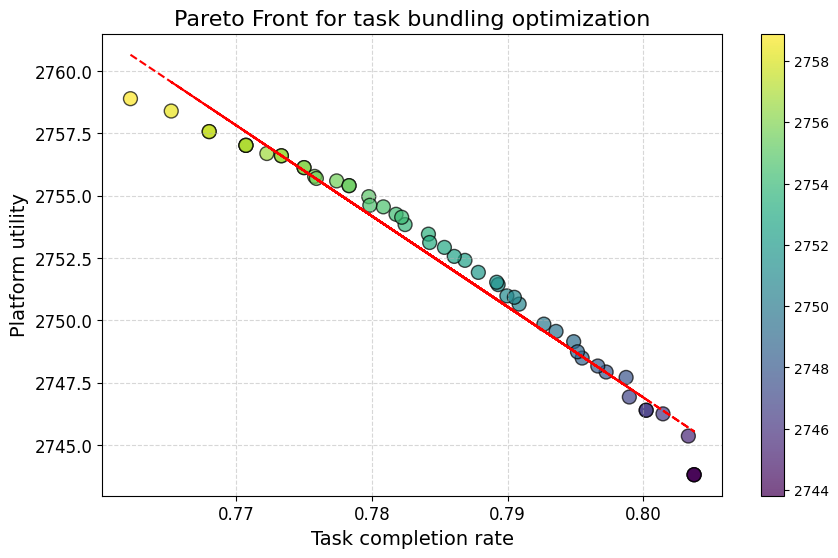

In [ ]:
import matplotlib.pyplot as plt

# 创建图像
plt.figure(figsize=(10, 6))
scatter = plt.scatter(completion_rates, total_values, c=total_values, cmap='viridis', edgecolor='k', s=100, alpha=0.7)
plt.colorbar(scatter)  # 添加颜色条
plt.title('Pareto Front for task bundling optimization', fontsize=16)
plt.xlabel('Task completion rate', fontsize=14)
plt.ylabel('Platform utility', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # 调整网格的样式和透明度

# 添加趋势线
z = np.polyfit(completion_rates, total_values, 1)
p = np.poly1d(z)
plt.plot(completion_rates, p(completion_rates), "r--")  # 红色虚线

plt.show()


#TBRM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# 定义Actor-Critic模型
class ActorCriticModel(tf.keras.Model):
    def __init__(self, n_bundles):
        super(ActorCriticModel, self).__init__()
        self.common = layers.Dense(128, activation='relu')
        self.actor = layers.Dense(n_bundles, activation='softmax')
        self.critic = layers.Dense(1)

    def call(self, inputs):
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

# 初始化模型、优化器和损失函数
n_bundles = 2
model = ActorCriticModel(n_bundles)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 定义奖励函数
def compute_reward(completion_rate, total_profit):
    return min(completion_rate, total_profit)

# 状态定义：可以是任务分配和任务距离矩阵的组合
def get_state(bundle_assignment, distances):
    # 简单将任务分配和距离矩阵合并为状态
    return np.concatenate([bundle_assignment, distances.flatten()])

# 动作选择：基于actor网络输出的概率分布
def select_action(actor_output):
    action_probabilities = tf.squeeze(actor_output).numpy()
    action = np.random.choice(len(action_probabilities), p=action_probabilities)
    return action
def rule_selection(action, bundle_assignment, distances):
    """
    从选择的动作中进行任务捆绑包的重组。
    action: 强化学习的动作，表示需要重组的捆绑包编号。
    bundle_assignment: 当前任务分配。
    distances: 任务之间的距离矩阵。
    """
    # 根据动作（action）选择任务捆绑包进行调整
    selected_bundle = action

    # 找出属于该捆绑包的所有任务
    bundle_tasks = [task for task, bundle in enumerate(bundle_assignment) if bundle == selected_bundle]

    if not bundle_tasks:
        return bundle_assignment  # 如果捆绑包为空，则不做任何调整

    # 随机选择一个任务从该捆绑包中移动到另一个捆绑包
    task_to_move = np.random.choice(bundle_tasks)

    # 随机选择一个新的捆绑包，将该任务重新分配
    new_bundle = np.random.choice(range(max(bundle_assignment) + 1))
    bundle_assignment[task_to_move] = new_bundle

    return bundle_assignment

# 更新模型参数
def update_model(state, action, reward, next_state, done):
    with tf.GradientTape() as tape:
        # 前向传播计算当前状态的actor和critic值
        actor_output, critic_value = model(tf.convert_to_tensor([state], dtype=tf.float32))
        next_actor_output, next_critic_value = model(tf.convert_to_tensor([next_state], dtype=tf.float32))

        # 计算优势函数
        target_value = reward + (1 - done) * 0.99 * next_critic_value
        advantage = target_value - critic_value

        # 计算Actor和Critic的损失
        actor_loss = -tf.math.log(actor_output[0, action]) * advantage
        critic_loss = advantage ** 2

        total_loss = actor_loss + critic_loss

    # 更新模型参数
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
def random_match(worker_positions, task_positions, bundle_assignment):
    random.seed(44)
    # 计算捆绑包和工人的距离矩阵
    bundle_distances = compute_distances(worker_positions, task_positions, bundle_assignment)

    # 初始化未匹配的工人和捆绑包
    unmatched_workers = list(range(len(worker_positions)))
    unmatched_bundles = list(range(len(bundle_distances)))
    total_distance = 0

    matched_workers = []
    matched_bundles = []

    # 随机分配工人到捆绑包
    while unmatched_workers and unmatched_bundles:
        # 随机选择一个未匹配的工人和一个未匹配的捆绑包
        worker_id = random.choice(unmatched_workers)
        bundle_id = random.choice(unmatched_bundles)

        # 记录该工人和捆绑包之间的距离
        current_distance = bundle_distances[bundle_id, worker_id]
        total_distance += current_distance

        # 更新已匹配列表
        matched_workers.append(worker_id)
        matched_bundles.append(bundle_id)

        # 从未匹配列表中移除
        unmatched_workers.remove(worker_id)
        unmatched_bundles.remove(bundle_id)

    return matched_workers, matched_bundles, total_distance
# 主循环 - 执行TBRM的强化学习，并输出工人总体旅行距离
def task_bundling_reinforcement_learning(bundle_assignment, task_completion_rates, distances, worker_positions, task_positions, n_iterations=50):
    for iteration in range(n_iterations):
        state = get_state(bundle_assignment, distances)
        actor_output, critic_value = model(tf.convert_to_tensor([state], dtype=tf.float32))

        # 选择动作（选择要重组的捆绑包和任务）
        action = select_action(actor_output)

        # 执行动作（重组任务捆绑包）
        next_bundle_assignment = rule_selection(action, bundle_assignment, distances)
        next_state = get_state(next_bundle_assignment, distances)

        # 计算完成率和总利润作为奖励
        completion_rate = np.mean([task_completion_rates[task] for task in range(len(bundle_assignment))])
        total_profit = eval_task_bundle(bundle_assignment, task_values, task_payments, task_completion_rates, distances, discount_rate)[1]
        reward = compute_reward(completion_rate, total_profit)

        done = iteration == n_iterations - 1  # 判断是否是最后一次迭代

        # 更新模型
        update_model(state, action, reward, next_state, done)

        # 更新任务捆绑
        bundle_assignment = next_bundle_assignment

        # 计算随机匹配下的工人和捆绑包的匹配情况以及总旅行距离
        matched_workers, matched_bundles, total_distance = random_match(worker_positions, task_positions, bundle_assignment)

        # 输出任务完成率均值、总价值和工人的总体旅行距离
        print(f"迭代 {iteration + 1}: 任务完成率均值 = {completion_rate}, 总价值 = {total_profit}, 工人的总体旅行距离 = {total_distance}")

    return bundle_assignment


# 使用强化学习运行TBRM
# 遍历 Pareto 前沿解并输出任务完成率、总价值和工人旅行距离
for solution in pareto_front:
    random.seed(44)
    # 将捆绑包编号从0开始改为1开始
    adjusted_solution = [x + 1 for x in solution]
    print("任务捆绑方案:", adjusted_solution)

    # 使用 eval_task_bundle 函数评估适应度（任务完成率均值和总价值）
    completion_rate, total_value = eval_task_bundle(solution, task_values, task_payments, task_completion_rates, distances, discount_rate)

    # 随机匹配工人和捆绑包并计算总旅行距离
    matched_workers, matched_bundles, total_distance = random_match(worker_positions, task_positions, solution)

    # 输出适应度值（任务完成率均值，总价值）和工人总旅行距离
    print(f"适应度（任务完成率均值, 总价值）: ({completion_rate}, {total_value}), 工人的总体旅行距离: {total_distance}")

    # 保存结果
    completion_rates.append(completion_rate)
    total_values.append(total_value)


任务捆绑方案: [2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1]
适应度（任务完成率均值, 总价值）: (0.76221538360318, 2758.892017154867), 工人的总体旅行距离: 1347.0
任务捆绑方案: [2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2]
适应度（任务完成率均值, 总价值）: (0.8037324291261309, 2743.81494344995), 工人的总体旅行距离: 1256.0
任务捆绑方案: [2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2]
适应度（任务完成率均值, 总价值）: (0.8037324291261309, 2743.81494344995), 工人的总体旅行距离: 1256.0
任务捆绑方案: [2, 2, 1, 2, 2,

# RaB

In [ ]:
import numpy as np
# 设置随机种子以保证可重复性
random.seed(44)
np.random.seed(44)
# 随机分配任务到捆绑包

bundle_assignment = np.random.randint(0, n_bundles, size=len(task_completion_rates))


# 初始化存储每个捆绑包的完成率和价值-成本
E = []
F = []
bundle_details = []
# 计算每个捆绑包的完成率和价值-成本
for bundle_id in range(n_bundles):
    bundle_tasks = [task for task in range(num_tasks) if bundle_assignment[task] == bundle_id]
    if not bundle_tasks:
        continue

    completion_rate = np.mean([task_completion_rates[task] for task in bundle_tasks])
    bundle_value = sum(task_values[task] for task in bundle_tasks)

    raw_cost = sum(task_payments[task] for task in bundle_tasks) # compensation_per_unit_distance * np.sum([distances[i][j] for i in bundle_tasks for j in bundle_tasks])
    discounted_cost = raw_cost * (1 - discount_rate)
    net_value = bundle_value - discounted_cost
    E.append(completion_rate)
    F.append(net_value)
    bundle_details.append(bundle_tasks)

def random_match(worker_positions, task_positions, bundle_assignment):
    random.seed(44)
    # 计算捆绑包和工人的距离矩阵
    bundle_distances = compute_distances(worker_positions, task_positions, bundle_assignment)

    # 初始化未匹配的工人和捆绑包
    unmatched_workers = list(range(len(worker_positions)))
    unmatched_bundles = list(range(len(bundle_distances)))
    total_distance = 0

    matched_workers = []
    matched_bundles = []

    # 随机分配工人到捆绑包
    while unmatched_workers and unmatched_bundles:
        # 随机选择一个未匹配的工人和一个未匹配的捆绑包
        worker_id = random.choice(unmatched_workers)
        bundle_id = random.choice(unmatched_bundles)

        # 记录该工人和捆绑包之间的距离
        current_distance = bundle_distances[bundle_id, worker_id]
        total_distance += current_distance

        # 更新已匹配列表
        matched_workers.append(worker_id)
        matched_bundles.append(bundle_id)

        # 从未匹配列表中移除
        unmatched_workers.remove(worker_id)
        unmatched_bundles.remove(bundle_id)

    return matched_workers, matched_bundles, total_distance

print(f"所有任务的平均完成率 = {np.mean(E)}, 所有任务的总价值 = {sum(F) * np.mean(E) }")

row_ind, col_ind, total_distance = random_match(worker_positions, task_positions, bundle_assignment)
print("匹配结果（捆绑包索引, 工人索引）:", list(zip(row_ind, col_ind)),"工人的总体旅行距离:", total_distance)


所有任务的平均完成率 = 0.7198739499341964, 所有任务的总价值 = 2730.481892100407
匹配结果（捆绑包索引, 工人索引）: [(52, 0), (22, 1)] 工人的总体旅行距离: 1327.0


# NoB

In [ ]:
import numpy as np
import random
# 设置随机种子以保证可重复性
random.seed(42)
np.random.seed(42)
# 存储每个任务的完成率和价值-成本
E = []
F = []

# 计算每个任务的完成率和价值-成本
for i in range(num_tasks):
    task = task_positions[i % len(task_positions)]
    worker = worker_positions[i % len(worker_positions)]

    # completion_rate = task_completion_rates[i]

    completion_rates_below_or_equal_05 = task_completion_rates[task_completion_rates <= popularity_threshold]
    completion_rates_below_or_equal_05

    value = task_values[i]
    payment = task_payments[i]

    # 计算工人到任务地点的曼哈顿距离
    distance = np.sum(np.abs(worker - task))
    distance_cost = distance #* compensation_per_unit_distance
    net_value = value - (payment + distance_cost)
    F.append(net_value)

    E.append(completion_rates_below_or_equal_05)
def manhattan_distance(p1, p2):
    """
    计算曼哈顿距离。
    """
    return np.sum(np.abs(p1 - p2))

def optimal_task_assignment(worker_positions, task_positions):
    """
    使用匈牙利算法对任务和工人进行最优匹配，以最小化曼哈顿距离。
    """
    num_workers = len(worker_positions)
    num_tasks = len(task_positions)

    # 创建距离矩阵
    distance_matrix = np.zeros((num_workers, num_tasks))
    for i, worker in enumerate(worker_positions):
        for j, task in enumerate(task_positions):
            distance_matrix[i, j] = manhattan_distance(worker, task)
    # 应用匈牙利算法进行最优匹配
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    # 计算最优匹配下的总距离
    total_distance = distance_matrix[row_ind, col_ind].sum()
    return row_ind, col_ind, total_distance

# 计算所有任务的平均完成率和总价值
average_completion_rate = np.mean(E)
total_value = sum(F)
print(f"所有任务的平均完成率 = {average_completion_rate:.4f}, 所有任务的总价值 = {total_value * average_completion_rate:.4f}")

row_ind, col_ind, total_distance = optimal_task_assignment(worker_positions, task_positions)
print("工人的总体旅行距离:", total_distance)



所有任务的平均完成率 = 0.1944, 所有任务的总价值 = 232.9066
工人的总体旅行距离: 458.0


# LocTB

In [ ]:
from scipy.optimize import linear_sum_assignment
random.seed(8)
np.random.seed(8)


# 计算每个任务到每个工人的曼哈顿距离并随机分配到捆绑包
distances_1 = np.array([[np.sum(np.abs(worker_position - task_position)) for task_position in task_positions] for worker_position in worker_positions])
bundle_assignment = np.random.randint(0, n_bundles, size=len(task_positions))  # 随机分配任务到捆绑包

# 捆绑包详情
bundle_details = [[] for _ in range(n_bundles)]
for task_id, bundle_id in enumerate(bundle_assignment):
    bundle_details[bundle_id].append(task_id)

# 计算捆绑包到工人的总距离
bundle_distances = np.zeros((n_bundles, len(worker_positions)))
for bundle_id in range(n_bundles):
    for worker_id in range(len(worker_positions)):
        if bundle_details[bundle_id]:
            bundle_distances[bundle_id, worker_id] = np.sum([distances_1[worker_id, task] for task in bundle_details[bundle_id]])

# 使用匈牙利算法找到最优匹配
row_ind, col_ind = linear_sum_assignment(bundle_distances)

# 初始化最优捆绑包给工人的匹配结果
optimal_bundle_assignment = [None] * len(worker_positions)
worker_task_distance = [None] * len(worker_positions)
for r, c in zip(row_ind, col_ind):
    optimal_bundle_assignment[c] = bundle_details[r]
    # 为每个工人存储与其捆绑包的距离
    worker_task_distance[c] = [distances_1[c, task] for task in bundle_details[r]]

# 计算每个捆绑包的完成率和价值-成本
E = []
F = []
D = []
for worker_id, bundle_tasks in enumerate(optimal_bundle_assignment):
    if bundle_tasks is None:
        continue
    # 使用匹配后的工人到任务的实际距离
    bundle_distances = worker_task_distance[worker_id] if worker_task_distance[worker_id] is not None else []

    completion_rate = np.mean([task_completion_rates[task] for task in bundle_tasks])
    bundle_value = sum(task_values[task] for task in bundle_tasks)
    raw_cost = sum(task_payments[task] for task in bundle_tasks) + compensation_per_unit_distance * np.sum(bundle_distances)
    discounted_cost = raw_cost * (1 - discount_rate)
    net_value = bundle_value - discounted_cost
    E.append(completion_rate)
    F.append(net_value)
    D.append(sum(bundle_distances))

# 输出结果
average_completion_rate = np.mean(E)
total_net_value = sum(F)

print(f"所有捆绑包的总平均完成率 = {average_completion_rate:.2f}, 所有任务的总价值 = {total_net_value * average_completion_rate:.2f}")


# row_ind, col_ind, total_distance = hungarian_match(worker_positions, task_positions, bundle_assignment)
# print("匹配结果（捆绑包索引, 工人索引）:", list(zip(row_ind, col_ind)),"工人的总体旅行距离:", total_distance)
print("工人的总体旅行距离:",sum(D))

所有捆绑包的总平均完成率 = 0.73, 所有任务的总价值 = 2754.88
工人的总体旅行距离: 1101
